In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import np_utils

from tensorflow.keras.utils import plot_model

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

# Data Loading

In [2]:
## GLOBAL VARIABLES
dataset = 'SA'
test_ratio = 0.9
windowSize = 9

In [3]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'PC':
        data = sio.loadmat(os.path.join(data_path, 'Pavia.mat'))['pavia']
        labels = sio.loadmat(os.path.join(data_path, 'Pavia_gt.mat'))['pavia_gt']
    elif name == 'BO':
        data = sio.loadmat(os.path.join(data_path, 'Botswana.mat'))['Botswana']
        labels = sio.loadmat(os.path.join(data_path, 'Botswana_gt.mat'))['Botswana_gt']
    return data, labels

In [4]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [6]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
X, y = loadData(dataset)

X.shape, y.shape

((512, 217, 204), (512, 217))

In [9]:
K = X.shape[2]
K

204

In [10]:
K = 100
X,pca = applyPCA(X,numComponents=K)

X.shape

(512, 217, 100)

In [11]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((54129, 9, 9, 100), (54129,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((5412, 9, 9, 100), (48717, 9, 9, 100), (5412,), (48717,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [13]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K,1)
Xtrain.shape

(5412, 9, 9, 100, 1)

In [14]:
ytrain =keras.utils.to_categorical(ytrain)
ytrain.shape

(5412, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [15]:
S = windowSize
L = K
if dataset == 'PU' or dataset == 'PC':
    output_units = 9
elif dataset == 'IP' or dataset == 'SA':
     output_units = 16
elif dataset == 'BO':
     output_units = 14

In [16]:
input_layer = Input((S, S, L,1))

conv_layer= Conv3D(filters=32, kernel_size=(1, 1, 3),dilation_rate=(1,1,3),activation='relu')(input_layer)
BN_layer=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer)
conv_layer= Conv3D(filters=8, kernel_size=(1, 1, 3),dilation_rate=(1,1,3),activation='relu')(BN_layer)
BN_layer=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer)





conv_layer1 = Conv3D(filters=4, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation='relu')(BN_layer)
BN_layer1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1)
conv_layer1_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation='relu')(BN_layer1)
BN_layer1_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1_1)
conv_layer1_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation='relu')(BN_layer1_1)
BN_layer1_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1_2)


conv_layer2 = Conv3D(filters=4, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation='relu')(BN_layer)
BN_layer2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer2)
conv_layer2_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation='relu')(BN_layer2)
BN_layer2_1=BatchNormalization(momentum=0.95,epsilon=1e-5)(conv_layer2_1)
conv_layer2_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation='relu')(BN_layer2_1)
BN_layer2_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer2_2)

conv_layer3 = Conv3D(filters=4, kernel_size=(3, 3, 7),  dilation_rate=(1,1,1),padding='same',activation='relu')(BN_layer)
BN_layer3=BatchNormalization(momentum=0.95,epsilon=1e-5)(conv_layer3)
conv_layer3_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,1),padding='same',activation='relu')(BN_layer3)
BN_layer3_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer3_1)
conv_layer3_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,1),padding='same',activation='relu')(BN_layer3_1)
BN_layer3_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer3_2)

ADD_layer=keras.layers.Add()([BN_layer1_2,BN_layer2_2,BN_layer3_2,BN_layer])


conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation='relu')(ADD_layer)
BN_layer1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1)
conv_layer1_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation='relu')(BN_layer1)
BN_layer1_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1_1)
conv_layer1_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation='relu')(BN_layer1_1)
BN_layer1_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1_2)



conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation='relu')(ADD_layer)
BN_layer2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer2)
conv_layer2_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation='relu')(BN_layer2)
BN_layer2_1=BatchNormalization(momentum=0.95,epsilon=1e-5)(conv_layer2_1)
conv_layer2_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation='relu')(BN_layer2_1)
BN_layer2_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer2_2)


conv_layer3 = Conv3D(filters=16, kernel_size=(3, 3, 7),  dilation_rate=(1,1,1),padding='same',activation='relu')(ADD_layer)
BN_layer3=BatchNormalization(momentum=0.95,epsilon=1e-5)(conv_layer3)
conv_layer3_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,1),padding='same',activation='relu')(BN_layer3)
BN_layer3_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer3_1)
conv_layer3_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,1),padding='same',activation='relu')(BN_layer3_1)
BN_layer3_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer3_2)


ADD_layer1=keras.layers.Add()([BN_layer1_2,BN_layer2_2,BN_layer3_2,BN_layer,ADD_layer])




conv_layer4 = Conv3D(filters=8, kernel_size=(1, 1, 1),activation='relu')(ADD_layer1)
BN_layer4=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer4)
conv_layer4_1 = Conv3D(filters=16, kernel_size=(3, 3, 11),strides=(1,1,1),padding='same',activation='relu')(BN_layer4)
BN_layer4_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer4_1)
conv_layer4_2 = Conv3D(filters=32, kernel_size=(1, 1, 1),activation='relu')(BN_layer4_1)
BN_layer4_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer4_2)

conv_layer4_3 = Conv3D(filters=32, kernel_size=(1, 1, 1),activation='relu')(ADD_layer1)
BN_layer4_3=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer4_3)

ResNet_layer1=keras.layers.Add()([BN_layer4_2, BN_layer4_3])



Pool_layer1=keras.layers.AveragePooling3D(pool_size=(2,2,2), padding="same")(ResNet_layer1)


conv_layer5= Conv3D(filters=32, kernel_size=(1,1,1), activation='relu')(Pool_layer1)
BN_layer5=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer5)
conv_layer5_1 = Conv3D(filters=64, kernel_size=(3,3,3),padding='same',activation='relu')(BN_layer5)
BN_layer5_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer5_1)
conv_layer5_2 = Conv3D(filters=128, kernel_size=(1,1,1), activation='relu')(BN_layer5_1)
BN_layer5_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer5_2)


conv_layer5_3= Conv3D(filters=128, kernel_size=(1,1,1),padding='same',activation='relu')(Pool_layer1)
BN_layer5_3=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer5_3)

ResNet_layer2=keras.layers.Add()([BN_layer5_2, BN_layer5_3])



Pool_layer2=keras.layers.AveragePooling3D(pool_size=(2,2,2))(ResNet_layer2)


flatten_layer = Flatten()(Pool_layer2)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


#output_layer = Dense(units=output_units, activation='softmax')(flatten_layer)

In [17]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [18]:
print(S)
print(L)
Xtrain.shape

9
100


(5412, 9, 9, 100, 1)

In [19]:
input_layer

<tf.Tensor 'input_1:0' shape=(None, 9, 9, 100, 1) dtype=float32>

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 100, 1 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 9, 9, 94, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 94, 32) 128         conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 9, 9, 88, 8)  776         batch_normalization[0][0]        
______________________________________________________________________________________________

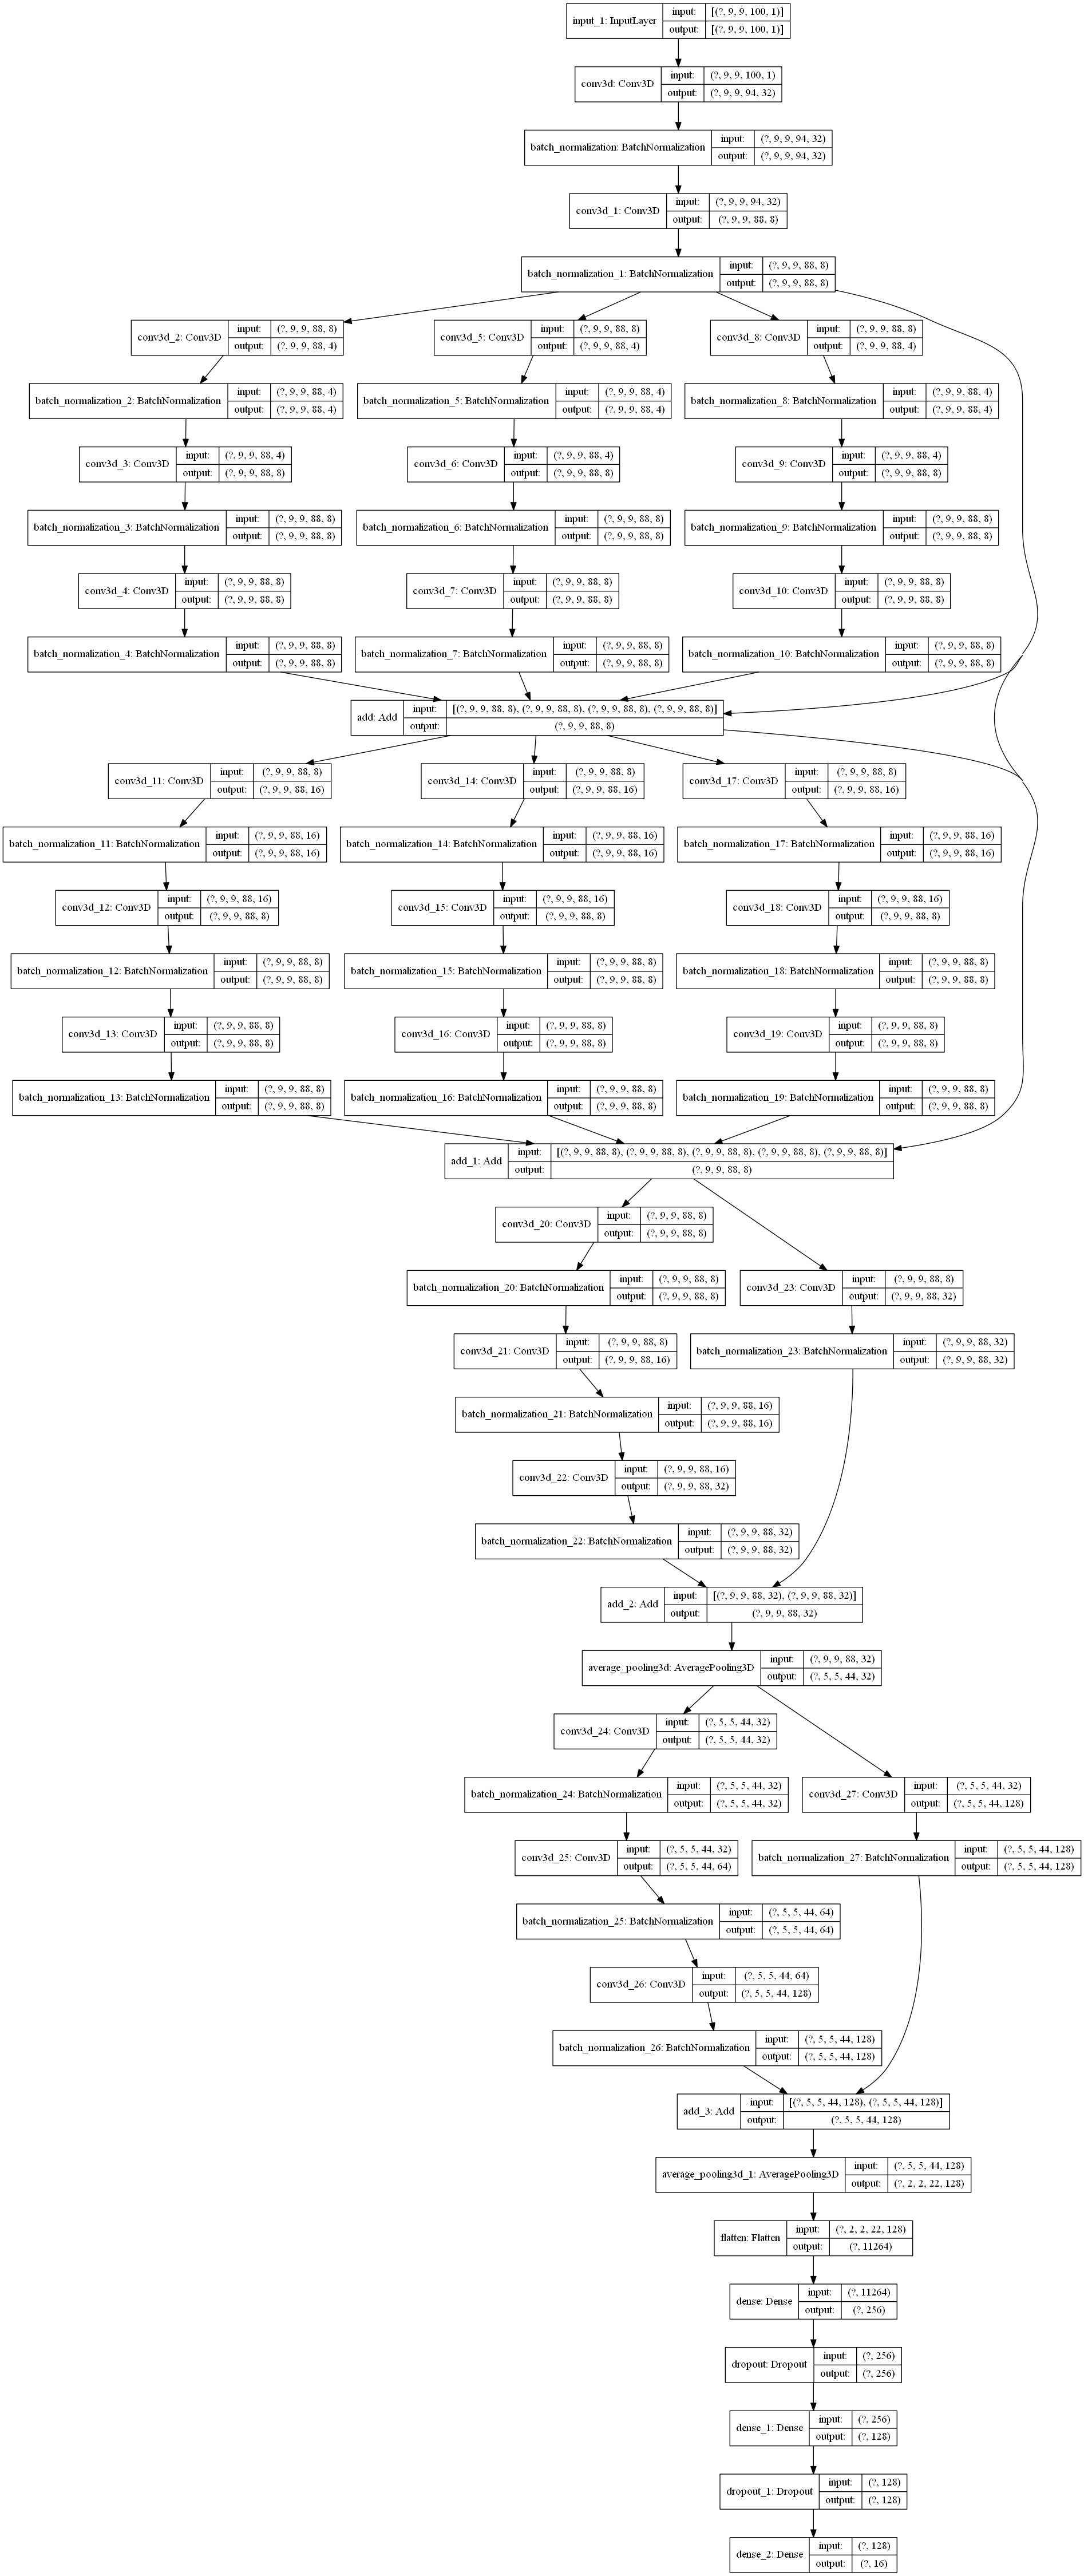

In [21]:
plot_model(model, to_file='MWS3DCN.png',show_shapes=True)

In [22]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [23]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100,callbacks=callbacks_list)

Train on 5412 samples
Epoch 1/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.6923 - accuracy: 0.8129
Epoch 00001: accuracy improved from -inf to 0.81393, saving model to best-model.hdf5
5412/5412 [==============================] - 168s 31ms/sample - loss: 0.6891 - accuracy: 0.8139
Epoch 2/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0867 - accuracy: 0.9732
Epoch 00002: accuracy improved from 0.81393 to 0.97339, saving model to best-model.hdf5
5412/5412 [==============================] - 154s 28ms/sample - loss: 0.0862 - accuracy: 0.9734
Epoch 3/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0551 - accuracy: 0.9849
Epoch 00003: accuracy improved from 0.97339 to 0.98485, saving model to best-model.hdf5
5412/5412 [==============================] - 154s 28ms/sample - loss: 0.0559 - accuracy: 0.9848
Epoch 4/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0425 - accuracy: 0.9879
Epoch 00004: accuracy improved fr

Epoch 32/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0547 - accuracy: 0.9914
Epoch 00032: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0543 - accuracy: 0.9915
Epoch 33/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0326 - accuracy: 0.9948
Epoch 00033: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0324 - accuracy: 0.9948
Epoch 34/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0298 - accuracy: 0.9939
Epoch 00034: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0325 - accuracy: 0.9933
Epoch 35/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0583 - accuracy: 0.9918
Epoch 00035: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0580 - accuracy: 0.9919
Epoch 36/100

5376/5412 [============================>.] - ETA: 1s - loss: 0.0253 - accuracy: 0.9972
Epoch 00065: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0252 - accuracy: 0.9972
Epoch 66/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0148 - accuracy: 0.9965
Epoch 00066: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0147 - accuracy: 0.9965
Epoch 67/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0013 - accuracy: 0.9996  
Epoch 00067: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0013 - accuracy: 0.9996
Epoch 68/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0177 - accuracy: 0.9974
Epoch 00068: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0176 - accuracy: 0.9974
Epoch 69/100
5376/5412 

Epoch 98/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0021 - accuracy: 0.9998
Epoch 00098: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0021 - accuracy: 0.9998
Epoch 99/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0026 - accuracy: 0.9998
Epoch 00099: accuracy did not improve from 1.00000
5412/5412 [==============================] - 153s 28ms/sample - loss: 0.0026 - accuracy: 0.9998
Epoch 100/100
5376/5412 [============================>.] - ETA: 1s - loss: 0.0238 - accuracy: 0.9974
Epoch 00100: accuracy did not improve from 1.00000
5412/5412 [==============================] - 154s 28ms/sample - loss: 0.0236 - accuracy: 0.9974


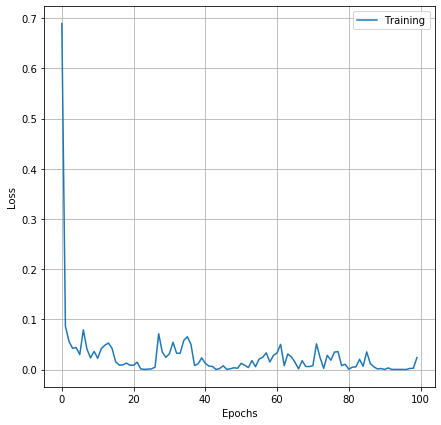

In [25]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

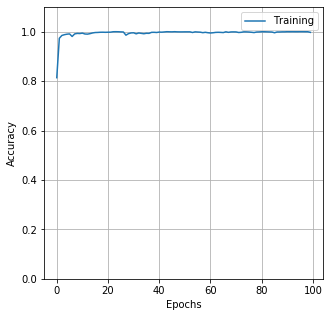

In [26]:
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [27]:
# load best weights
model=keras.models.load_model("best-model.hdf5")

In [28]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K,1)
Xtest.shape

(48717, 9, 9, 100, 1)

In [29]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(48717, 16)

Xtest1=Xtest[0:10]
Xtest2=Xtest[11:-1]
ytest1=ytest[0:10]
ytest2=ytest[11:-1]
Xtest2.shape


In [30]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test,digits=6)
print(classification)

              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      1808
           1   1.000000  1.000000  1.000000      3354
           2   1.000000  1.000000  1.000000      1779
           3   0.995242  1.000000  0.997615      1255
           4   1.000000  0.997510  0.998754      2410
           5   1.000000  1.000000  1.000000      3563
           6   1.000000  1.000000  1.000000      3221
           7   0.999901  0.999606  0.999754     10144
           8   0.999105  1.000000  0.999552      5583
           9   1.000000  0.998305  0.999152      2950
          10   1.000000  1.000000  1.000000       961
          11   0.999424  1.000000  0.999712      1734
          12   0.996377  1.000000  0.998185       825
          13   1.000000  0.996885  0.998440       963
          14   0.999541  0.999847  0.999694      6541
          15   1.000000  1.000000  1.000000      1626

    accuracy                       0.999610     48717
   macro avg   0.999349  0

In [31]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [32]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'BO':
        target_names = ['Water','Hippo_grass','Floodpain_grasses_1','Floodpain_grasses_2','Reeds','Riparian','Firescar',
                        'Island_interior','Acacia_woodlands','Acacia_shrublands','Acacia_grasslands','Short_mopane',
                        'Mixed_mopane','Exposed_soils']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names,digits=6)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [33]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

48717/48717 [==============================] - 402s 8ms/sample - loss: 0.0027 - accuracy: 0.9996


In [34]:
classification
print(classification)

                           precision    recall  f1-score   support

    Brocoli_green_weeds_1   1.000000  1.000000  1.000000      1808
    Brocoli_green_weeds_2   1.000000  1.000000  1.000000      3354
                   Fallow   1.000000  1.000000  1.000000      1779
        Fallow_rough_plow   0.995242  1.000000  0.997615      1255
            Fallow_smooth   1.000000  0.997510  0.998754      2410
                  Stubble   1.000000  1.000000  1.000000      3563
                   Celery   1.000000  1.000000  1.000000      3221
         Grapes_untrained   0.999901  0.999606  0.999754     10144
     Soil_vinyard_develop   0.999105  1.000000  0.999552      5583
Corn_senesced_green_weeds   1.000000  0.998305  0.999152      2950
      Lettuce_romaine_4wk   1.000000  1.000000  1.000000       961
      Lettuce_romaine_5wk   0.999424  1.000000  0.999712      1734
      Lettuce_romaine_6wk   0.996377  1.000000  0.998185       825
      Lettuce_romaine_7wk   1.000000  0.996885  0.998440     

In [35]:
confusion
print(confusion)

[[ 1808     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0  3354     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0  1779     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0  1255     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     6  2404     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0  3563     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0  3221     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0 10140     0     0     0     1
      0     0     3     0]
 [    0     0     0     0     0     0     0     0  5583     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     5  2945     0     0
      0     0    

In [36]:
Test_loss

0.273597338597473

In [37]:
Test_accuracy

99.96100068092346

In [38]:
oa

99.96099924051153

In [39]:
each_acc
print(each_acc)

[100.         100.         100.         100.          99.75103734
 100.         100.          99.96056782 100.          99.83050847
 100.         100.         100.          99.68847352  99.98471182
 100.        ]


In [40]:
aa

99.95095618627079

In [41]:
kappa

99.95657369476343

In [42]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [43]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [44]:
# load the original image
X, y = loadData(dataset)

In [45]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [46]:
X,pca = applyPCA(X, numComponents=numComponents)

In [47]:
X = padWithZeros(X, PATCH_SIZE//2)

In [48]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

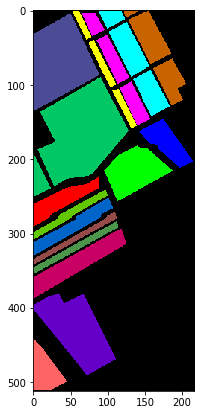

In [49]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

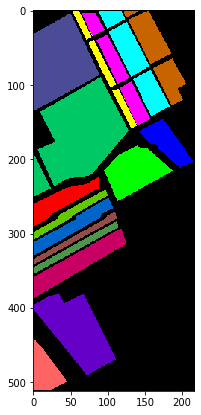

In [50]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [51]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [52]:
spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)